In [1]:
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import Tuple, List

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve,learning_curve

In [2]:
data=pd.read_csv('data30.csv')
print('data.shape={} rows, {} columns'.format(*data.shape))
print(f'data {len(data.index)} rows, {len(data.axes[1])} columns')
data.head(4)

data.shape=100000 rows, 394 columns
data 100000 rows, 394 columns


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data[['TransactionAmt', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1']].isna().sum()

TransactionAmt    0
card1             0
C1                0
C2                0
C3                0
C4                0
C5                0
C6                0
C7                0
C8                0
C9                0
C10               0
C11               0
C12               0
C13               0
C14               0
D1                0
dtype: int64

In [4]:
x_train, x_valid=train_test_split(data
    [[ 'TransactionAmt', 'card1', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1']],
                                  train_size=0.7, shuffle=True, random_state=1)

y_train, y_valid=train_test_split(data['isFraud'], train_size=0.7, shuffle=True, random_state=1)

print(f'x_train = {len(x_train.axes[0])} rows, {len(x_train.axes[1])} columns')
print(f'x_valid = {len(x_valid.axes[0])} rows, {len(x_valid.axes[1])} columns')

x_train = 70000 rows, 17 columns
x_valid = 30000 rows, 17 columns


In [5]:
def fit_evaluate_model(estimator, x_train, y_train, x_valid, y_valid):
    
    estimator.fit(x_train, y_train)
    y_train_pred=estimator.predict_proba(x_train)[:,1]
    y_valid_pred=estimator.predict_proba(x_valid)[:,1]
    
    train_score=roc_auc_score(y_train, y_train_pred)
    valid_score=roc_auc_score(y_valid, y_valid_pred)
    print(f' Model score: train = {round(train_score, 4)}, valid = {round(valid_score, 4)}')
    
    return y_train_pred, y_valid_pred

def plot_validation_curves(train_scores: np.array, valid_scores: np.array, figsize: Tuple[int, int] = (8, 8)):
    
    fig=plt.figure(figsize=figsize)
    
    plt.title('Validation Curves', size=15)
    
    plt.plot(range(train_scores.shape[0]), np.mean(train_scores, axis=1), label='Train', linewidth=3, marker='s')
    
    plt.fill_between(x=range(train_scores.shape[0]), y1=np.mean(train_scores, axis=1)-np.std(train_scores, axis=1), y2=np.mean(train_scores, axis=1)+np.std(train_scores, axis=1), alpha=0.25)
    
    plt.plot(range(train_scores.shape[0]), np.mean(valid_scores, axis=1), label='Valid', linewidth=3, marker='s')
    
    plt.fill_between(x=range(train_scores.shape[0]), y1=np.mean(valid_scores, axis=1)-np.std(valid_scores, axis=1), y2=np.mean(valid_scores, axis=1)+np.std(valid_scores, axis=1), alpha=0.25)
    
    plt.legend(loc='best', fontsize=14)
    plt.ylabel('roc_auc', size=15)
    

In [6]:
forest=RandomForestClassifier(random_state=27)

y_train_pred, y_valid_pred=fit_evaluate_model(forest, x_train, y_train, x_valid, y_valid)

 Model score: train = 0.9998, valid = 0.8984


In [7]:
%%time
train_scores, valid_scores = validation_curve(
    X=x_train,
    y=y_train,
    estimator=forest,
    param_range=range(2, 15),
    param_name="max_depth",
    scoring="roc_auc",
    n_jobs=1,
    cv=3,
)

Wall time: 1min 43s


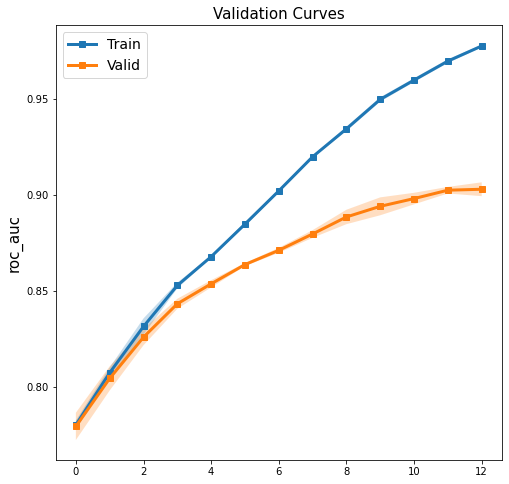

In [8]:
plot_validation_curves (train_scores, valid_scores)

In [9]:
def create_bootstrap_samples(data: np.array, n_samples: int=1000) -> np.array:
    
    bootstrap_index=np.random.randint(low=0, high=len(data), size=(n_samples, len(data)))
    
    return bootstrap_index

def create_bootstrap_metrics(y_true: np.array, y_pred: np.array, metric: callable, n_samples: int=1000)->List[float]:
    
    scores=[]
    
    if isinstance(y_true, pd.Series):
        y_true =y_true.values
        
    bootstrap_index=create_bootstrap_samples(y_true)
    for idx in bootstrap_index:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]
        
        score= metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)
        
    return scores
    
def calculate_confidence_interval(scores: list, conf_interval: float=0.95)-> Tuple[float]:
    
    left_bound = np.percentile(scores, ((1-conf_interval)/2)*100)
    right_bound = np.percentile(scores, (conf_interval+((1-conf_interval)/2))*100)    
    
    return round(left_bound, 4), round(right_bound, 4), round(left_bound+right_bound, 4)

In [10]:
%%time
forest=RandomForestClassifier(max_depth=14, random_state=27)

y_train_pred, y_valid_pred=fit_evaluate_model(forest, x_train, y_train, x_valid, y_valid)

 Model score: train = 0.9714, valid = 0.9078
Wall time: 6.04 s


In [12]:
%%time
np.random.seed(27)
scores = create_bootstrap_metrics(y_valid, y_valid_pred, roc_auc_score)
calculate_confidence_interval(scores)

Wall time: 7.13 s


(0.8932, 0.9221, 1.8153)